<a href="https://colab.research.google.com/github/ShahrukhS/CE888-Data-Science/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
np.set_printoptions(precision = 3)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ShahrukhS/CE888-Data-Science/main/Lab_4/dataset/jester-data-1.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24983 entries, 0 to 24982
Columns: 101 entries, 0 to 100
dtypes: float64(100), int64(1)
memory usage: 19.3 MB


In [8]:
df.drop([0], axis=1, inplace=True)
df.replace(99, np.NaN, inplace=True)

In [9]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


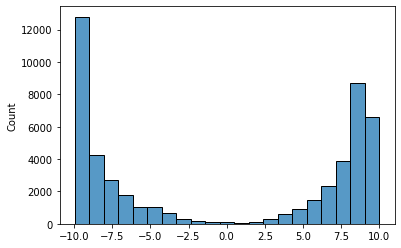

In [12]:
sns.histplot(data=df.min(axis=1).append(df.max(axis=1)))

In [17]:
arr = df.to_numpy()
rated = np.where(arr != np.NaN)
rated[1].shape

(2498300,)

In [15]:
def replace(orig, percentage=0.1):
        """
        Replaces 'percentage'% of the original values in 'orig' with 99's
        :param orig: original data array
        :param percentage: percentage of values to replace (0<percentage<1)
        """
        new_data = orig.copy()
        rated = np.where(arr != np.NaN)
        n_rated = len(rated[0])
        idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
        new_data[rated[0][idx], rated[1][idx]] = np.NaN
        return new_data, (rated[0][idx], rated[1][idx])

In [18]:
val_arr, idx = replace(arr, 0.1)
print('initially:', arr[idx[0][0], idx[1][0]])
print('after replace function', val_arr[idx[0][0], idx[1][0]])

initially: -2.82
after replace function nan


In [19]:
val_arr.shape

(24983, 100)

In [20]:
n_latent_factors = 2

latent_user_preferences = np.random.random((val_arr.shape[0], n_latent_factors))
latent_item_features = np.random.random((val_arr.shape[1], n_latent_factors))

In [21]:
latent_item_features[:5]

array([[0.076, 0.788],
       [0.819, 0.415],
       [0.659, 0.681],
       [0.666, 0.786],
       [0.165, 0.344]])

In [22]:
def predict_rating(user_id, item_id):
        """ Predict a rating given a user_id and an item_id.
        """
        user_preference = latent_user_preferences[user_id]
        item_preference = latent_item_features[item_id]
        return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
        #print(item_id)
        predicted_rating = predict_rating(user_id, item_id)
        err = predicted_rating - rating
        #print(err)
        user_pref_values = latent_user_preferences[user_id]
        latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
        latent_item_features[item_id] -= alpha * err * user_pref_values
        return err


def sgd(iterations):
        """ Iterate over all users and all items and train for 
            a certain number of iterations
        """
        mse_history = []
        for iteration in range(iterations):
            error = []
            for user_id in range(latent_user_preferences.shape[0]):
                for item_id in range(latent_item_features.shape[0]):
                    rating = val_arr[user_id, item_id]
                    if not np.isnan(rating):
                        err = train(user_id, item_id, rating)
                        error.append(err)
            mse = (np.array(error) ** 2).mean()   
            if (iteration % 2) == 0:
                print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
                mse_history.append(mse)
        return mse_history

Iteration 0/10:	MSE=26.234669
Iteration 2/10:	MSE=25.002500
Iteration 4/10:	MSE=24.573787
Iteration 6/10:	MSE=24.146931
Iteration 8/10:	MSE=23.713527


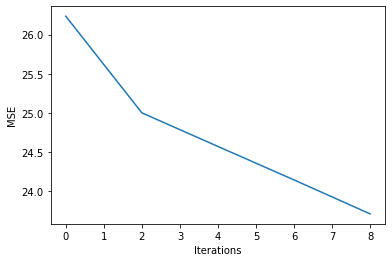

In [23]:
num_iter = 10
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 2), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [24]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[1.629, 0.98 , 1.058, ..., 1.895, 0.709, 2.487],
       [1.191, 0.752, 0.774, ..., 1.374, 0.545, 1.974],
       [1.748, 1.074, 1.136, ..., 2.027, 0.778, 2.767],
       ...,
       [0.315, 0.166, 0.205, ..., 0.374, 0.12 , 0.382],
       [0.962, 0.543, 0.625, ..., 1.13 , 0.393, 1.318],
       [1.731, 1.023, 1.124, ..., 2.02 , 0.741, 2.566]])

In [25]:
values = [zip(val_arr[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = df.columns

#### Final snapshot of the data
with each data point as (original value, prediction)

In [27]:
comparison_data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,"(-7.82, 1.6291029228067715)","(8.79, 0.9795547321610506)","(nan, 1.058234857308756)","(-8.16, -1.0246314033114996)","(-7.52, 1.0506033794272465)","(-8.5, 2.773930855213705)","(-9.85, -0.04294727071544219)","(4.17, -0.5077151300900662)","(-8.98, -0.07826621480179326)","(-4.76, 2.0310987431272465)","(-8.5, 3.0165126104313083)","(-6.75, 2.732661053068495)","(-7.18, -1.8832775860569229)","(8.45, 2.681177285192394)","(-7.18, -1.9439802706412737)","(-7.52, -3.6560401127385576)","(-7.43, -0.9429663090572588)","(-9.81, -0.43956387761805626)","(-9.85, 0.7572219519564279)","(-9.85, -0.5795123108276302)","(-9.37, 3.459502730955479)","(1.5, 1.870035277048712)","(-4.37, 0.7884722602991219)","(-9.81, -1.4858466679876698)","(-8.5, 1.3121235094679766)","(1.12, 2.4932082787131513)","(7.82, 4.635649863787731)","(2.86, 2.622056119133171)","(9.13, 4.400193044119476)","(-7.43, 0.2792138361131038)","(2.14, 3.5761777914612973)","(-4.08, 4.59024996709115)","(-9.08, -0.9057197307820507)","(7.82, 2.0200105669232293)","(5.05, 4.477034638602166)","(4.95, 4.687442758602387)","(-9.17, -1.1012726734622005)","(-8.4, 2.2493795332061524)","(-8.4, 2.2239456316542343)","(nan, 2.0935978546342096)",...,"(8.59, 3.889846270211368)","(3.59, 4.410585534983897)","(-6.84, 1.1591852553406268)","(-9.03, -0.18014234888983627)","(2.82, 3.647727178435652)","(-1.36, 3.9026948020921837)","(-9.08, -0.3957193756192727)","(8.3, 3.998217070859297)","(5.68, 3.994914546579764)","(-4.81, 1.4256283890276356)","(nan, -0.06323700362257796)","(nan, 4.074666035090163)","(nan, 2.1845411334578637)","(nan, -1.0644301341862958)","(nan, 0.435582328589661)","(nan, 3.7458094824408774)","(nan, 1.7014788171873383)","(nan, 2.900651720838601)","(nan, 1.0456088733256468)","(nan, 2.327308329544438)","(nan, 3.0196305653530455)","(-7.72, 1.8242576792787277)","(nan, 3.30325004334691)","(nan, 1.6758888347110414)","(nan, 1.937432128829554)","(nan, 0.975953829131828)","(nan, 3.009341928495438)","(nan, 3.188608051516406)","(nan, 4.887209403342956)","(nan, 1.5793127130195872)","(2.82, 3.050836763425011)","(nan, 2.208037977288987)","(nan, 3.726427073403933)","(nan, 1.9965794812279685)","(nan, 1.9294306993800208)","(nan, 2.5655929597315548)","(-5.63, 2.661076821490705)","(nan, 1.8954434455459714)","(nan, 0.7091593211164463)","(nan, 2.4873085438877385)"
1,"(4.08, 1.1909006622050735)","(-0.29, 0.7523257854485442)","(6.36, 0.7736651875666752)","(4.37, -0.833608556499311)","(-2.38, 0.7902420939420676)","(-9.66, 2.0835871331545177)","(-0.73, -0.10592982547105848)","(nan, -0.3593027326061808)","(8.88, -0.16291789059592524)","(9.22, 1.5667094193018118)","(6.75, 2.326675012536508)","(8.64, 2.085170359307504)","(4.42, -1.5281169596523558)","(7.43, 2.0534463997515746)","(4.56, -1.5070561656172456)","(-0.97, -2.834317102521985)","(4.66, -0.7639301928649205)","(-0.68, -0.4055601056414433)","(3.3, 0.5176704155153367)","(-1.21, -0.5303787950992502)","(0.87, 2.7248451466160066)","(8.64, 1.368025877012217)","(8.35, 0.6270912593712968)","(9.17, -1.223597097796584)","(0.05, 0.956399029602891)","(7.57, 1.925225734972148)","(4.71, 3.539118834192359)","(0.87, 2.046189210289099)","(-0.39, 3.3755759422084637)","(6.99, 0.17712137539920014)","(6.5, 2.7687987347885445)","(-0.92, 3.5103518383694334)","(7.14, -0.7936603180536553)","(9.03, 1.4998867512874088)","(-1.8, 3.463411140027093)","(0.73, 3.64249098528305)","(7.09, -0.9164399174354428)","(3.4, 1.7290807661814493)","(-0.87, 1.7192701765009797)","(7.91, 1.5887860773845943)",...,"(-6.7, 2.9579647724659557)","(-3.35, 3.357024080384003)","(-9.03, 0.7982671633387138)","(nan, -0.2849185315768394)","(4.08, 2.874761581141077)","(-3.83, 3.0031812574888566)","(8.74, -0.3750454636680812)","(1.12, 3.0831957832323753)","(0.78, 3.109353782227645)","(7.52, 1.0242

###  Lab Quiz

In [45]:
df.iloc[9859, 56]

-6.65

In [38]:
df_excel_items = pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx')
df_excel_users = pd.read_excel('https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/movies_latent_factors.xlsx', sheet_name='Users')

In [56]:
df_excel_items['Movie ID'].unique()

array([   11,    12,    13,    14,    22,    24,    38,    63,    77,
          85,    98,   105,   107,   114,   120,   121,   122,   134,
         141,   146,   153,   155,   161,   180,   187,   194,   197,
         238,   243,   268,   272,   274,   275,   278,   280,   329,
         393,   414,   424,   453,   462,   550,   557,   558,   568,
         581,   585,   597,   601,   602,   603,   604,   607,   629,
         640,   641,   664,   671,   672,   680,   745,   752,   786,
         788,   807,   808,   809,   812,   854,   857,   862,   954,
         955,  1422,  1572,  1597,  1637,  1891,  1892,  1894,  1900,
        2024,  2164,  2501,  2502,  3049,  4327,  5503,  7443,  8358,
        8467,  8587,  9331,  9741,  9802,  9806, 10020, 36657, 36658,
       36955])

In [44]:
df_excel_users['User'].unique()

array([4768,  156, 5323,  174, 4529,  783, 3878,  768, 4469, 1882, 4997,
       2067, 3806, 2848, 4433, 3519, 5338, 3947, 4373, 2092,  525, 4327,
       3048, 2665, 4940])

In [46]:
index = df_excel_users['User'][df_excel_users['User'] == 3947].index
df_excel_users.loc[index, ['User', 'Factor3']]

,User,Factor3
17,3947,-0.13698


In [48]:
factor = 'Factor5'
highest_loading = df_excel_items.loc[:, factor].max()
index = df_excel_items[factor][df_excel_items[factor] == highest_loading].index
df_excel_items.loc[index, ['Movie ID', 'Title', factor]]

,Movie ID,Title,Factor5
15,121,The Lord of the Rings: The Two Towers (2002),2.750878


In [54]:
latent_user_preferences = df_excel_users.drop(['User'], axis=1).to_numpy()
latent_item_features = df_excel_items.drop(['Movie ID', 'Title'], axis=1).T.to_numpy()

In [55]:
ratings = latent_user_preferences.dot(latent_item_features)

In [57]:
movie_df = pd.DataFrame(ratings)
movie_df.columns = df_excel_items['Movie ID'].values
movie_df.set_index(df_excel_users['User'].values, inplace=True)

In [58]:
round(movie_df.loc[3048, 2164], 2)

-0.22

In [59]:
movie_df.loc[3947].sort_values(ascending=False)

603     0.582245
604     0.578413
453     0.431327
153     0.314619
2501    0.313001
          ...   
4327   -0.342341
187    -0.524426
680    -0.614693
393    -2.224573
24     -2.425533
Name: 3947, Length: 100, dtype: float64

In [60]:
movie_df.loc[3806].sort_values(ascending=False)

603      0.892839
854      0.872107
604      0.741588
607      0.639684
3049     0.627290
           ...   
558     -0.562430
597     -0.582490
10020   -0.645776
393     -0.895120
24      -0.961029
Name: 3806, Length: 100, dtype: float64